# Prática V

Eduardo Garcia Misiuk - 9293230 
Mauricio Caetano da Silva - 9040996

Datasets escolhidos: Titanic

# Titanic

### Carregando os dados

In [136]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

att = ['Survived','Pclass','Age','SibSp','Parch','Fare']
titanic = pd.read_csv('titanic.csv', usecols=att)

separator = "\n============================================================================================================\n"
columns = titanic.columns.tolist()

titanic.head(n=10)



,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500
5,0,3,NaN,0,0,8.4583
6,0,1,54.0,0,0,51.8625
7,0,3,2.0,3,1,21.0750
8,1,3,27.0,0,2,11.1333
9,1,2,14.0,1,0,30.0708


### Algoritmo de classificação

In [137]:
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from numpy import mean, std


def classificacao(data, columns, target, weights):
    """
    Executa classificação do conjunto de dados passado
    ---------------------------------------------------------------
    data:       DataFrame. Conjunto de dados
    columns:    Lista de inteiros. Índice das colunas utilizadas no treinamento e teste
    target:     Inteiro. Índice da coluna alvo
    weights:    Dicionário. Pesos das classes, cada chave do dicionário é a classe e seu valor a probabilidade
    ---------------------------------------------------------------
    Realiza a classificação em 3 modelos (SVM com kernel linear, 
    SVM com kernel polinomial de grau 3, Árvore de decisão)
    Plot o gráfico de desempenho para cada classificador.
    Retorna um dicionário com os classificadores treinados e as medidas de desempenho
    """
    
    # inicializa os modelos com os parâmetros solicitados
    svm_l = SVC(C=10*len(data), kernel='linear', cache_size=500, max_iter=1e6, class_weight=weights)
    svm_n = SVC(C=10*len(data), kernel='poly', degree=3, gamma=1, coef0=1, cache_size=500, max_iter=1e6, class_weight=weights)
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=int(len(data)*0.1), class_weight=weights)
    
    clfs = [svm_l, svm_n, dt]
    clfs_names = ['svm_linear', 'svm_poly', 'dt']
    
    # prepara validação cruzada
    # faz divisão do dataset em 5 partes
    cv = KFold(n_splits=5, shuffle=True)
    
    # itera para cada classificador fazendo treino e teste
    results = {'svm_linear':[], 'svm_poly':[], 'dt':[]}
    for c, c_name in zip(clfs, clfs_names):
        for train_index, test_index in cv.split(data):
            
            # separa conjunto de treino e de teste
            x_train, y_train = data.iloc[train_index, columns], data.iloc[train_index, target]
            x_test, y_test = data.iloc[test_index, columns], data.iloc[test_index, target]
            
            # faz o treino do modelo
            clf = c.fit(X=x_train, y=y_train)
            
            # realiza predição no conjunto de teste e salva o resultado
            results[c_name].append( clf.score(x_test, y_test) )
    
    # faz o plot de desempenho dos classificadores
    plt.figure(figsize=(8,8))
    plt.bar(range(1, len(clfs)+1), [mean(results[name]) for name in clfs_names], 
                                yerr=[std(results[name]) for name in clfs_names])
    plt.xticks(range(1, len(clfs)+1), clfs_names, rotation=45)
    title = 'Desempenho dos classificadores - acurácia'
    plt.title(title)
    plt.show()
    
    return {'results': results, 'clfs':clfs}

### Questão 1

**O desbalanceamento, em geral, causa problemas para a classificação. Trate o desbalanceamento utilizando as abordagens de subamostragem, superamostragem. Mostre a distribuição das classes após o balanceamento.**

**Para realizar a subamostragem e a superamostragem chame a função sample do DataFrame. Abaixo tem um exemplo de como utilizar essa função. Utilize a função classificação definida abaixo ajustando o parâmetro weights para um valor que você ache adequado. Esse parâmetro faz com que o algoritmo de classificação leve em conta o peso da classe no processo de treinamento.**

**Utilize 2 valores de weights diferentes e comente o resultado (o que você acha que mudou com esses valores diferentes de weights).**

In [33]:
# O algoritmo não roda com valores NaN, portanto precisamos primeiro tirá-los
clean = titanic.dropna()

print('Distribuição de classes original')
print(clean.iloc[:, 0].groupby(clean.iloc[:, 0]).count())

Distribuição de classes original
Survived
0    424
1    290
Name: Survived, dtype: int64


In [34]:
# Numero total de instancias
n = clean.count()[0]

# Como foi verificado no snippet anterior, há mais valores 0 do que 1 na classe Survived
# O primeiro sample terá mais instâncias com classe 1
# O segundo sample terá mais instâncias com classe 0
# O terceiro será totalmente balanceado

# Probabilidades
probs1 = {0: 1/3, 1: 2/3}
probs2 = {0: 2/3, 1: 1/3}
# Probabilidades na matriz
sp1 = clean.iloc[:, 0].copy()
sp2 = clean.iloc[:, 0].copy()

# Mais classe 1
for c in sp1.unique():
    sp1[sp1 == c] = probs1[c]
s1 = clean.sample(frac=1, replace=True, axis=0, weights=sp1)
print(s1.iloc[:, 0].groupby(s1.iloc[:, 0]).count())
print(separator)

# Mais classe 0
for c in sp2.unique():
    sp2[sp2 == c] = probs2[c]
s2 = clean.sample(frac=1, replace=True, axis=0, weights=sp2)
print(s2.iloc[:, 0].groupby(s2.iloc[:, 0]).count())
print(separator)

# Número igual de cada classe (no caso, pegamos o máximo que pudemos, que é 342)
s3 = [clean.loc[clean.iloc[:, 0] == c].sample(n=290, replace=True) for c in clean.iloc[:, 0].unique()]
s3 = pd.concat(s3)
print(s3.iloc[:, 0].groupby(s3.iloc[:, 0]).count())

Survived
0    303
1    411
Name: Survived, dtype: int64


Survived
0    530
1    184
Name: Survived, dtype: int64


Survived
0    290
1    290
Name: Survived, dtype: int64


/home/misiuk/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


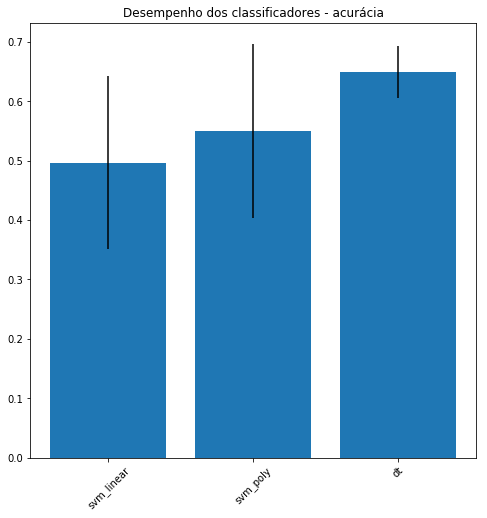

In [38]:
cols = range(1,6)
c1 = classificacao(clean, cols, 0, weights={0:1/3, 1:2/3})

/home/misiuk/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


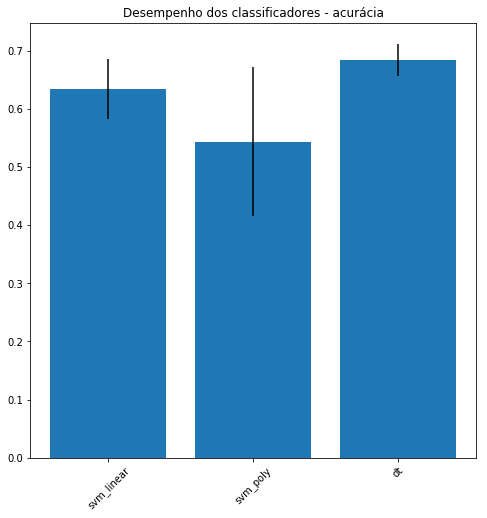

In [39]:
c2 = classificacao(clean, cols, 0, weights={0:2/3, 1:1/3})

/home/misiuk/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


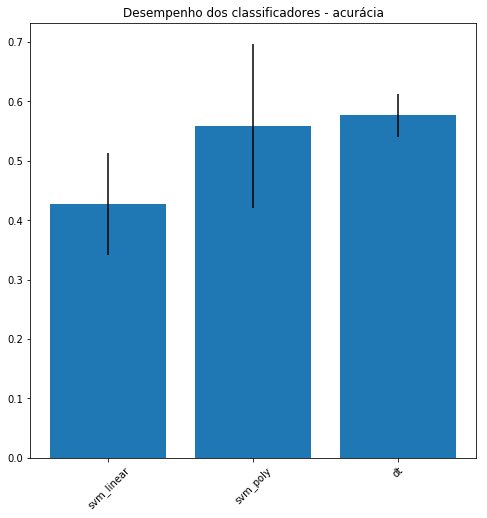

In [40]:
c3 = classificacao(clean, cols, 0, weights={0:1/5, 1:4/5})

/home/misiuk/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


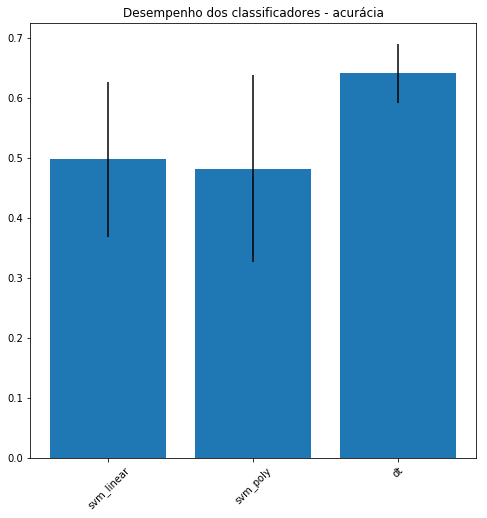

In [41]:
c4 = classificacao(clean, cols, 0, weights={0:4/5, 1:1/5})

Discorreremos brevemente sobre os resultados de cada algoritmo.
- svm_linear: os pesos não muito diferentes entre si não piorou o resultado da classificação, mas quando os pesos diferiam mais, obtivemos os piores resultados.
- svm_poly: não houve uma grande diferença entre os resultados, sendo o último o pior resultado.
- dt: pesos com valores mais próximos resultaram em melhores resultados, sendo este o algoritmo que melhor classificou os dados.

### Questão 2)
**Faça a conversão entre tipos para dois atributos. Escolha as conversões que achar mais adequada, quantitativo para qualitativo ou qualitativo para quantitativo. Explique o que você fez e porque achou essa a melhor forma de fazer. Para referência consulte os slides 9-21.**

Mudaremos os atributos Pclass e Survived.

**Pclass:**
- 1: (1, 0, 0)
- 2: (0, 1, 0)
- 3: (0, 0, 1)

**Survived:**
- 0: (1, 0)
- 1: (0, 1)

In [92]:
clean.head(n=10)

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500
6,0,1,54.0,0,0,51.8625
7,0,3,2.0,3,1,21.0750
8,1,3,27.0,0,2,11.1333
9,1,2,14.0,1,0,30.0708
10,1,3,4.0,1,1,16.7000


In [96]:
ca = pd.DataFrame(columns=columns)

for c in clean.values:
    temp = {}

    # Copiando os elementos que não serão mudados
    temp['Age'] = c[2]
    temp['SibSp'] = c[3]
    temp['Parch'] = c[4]
    temp['Fare'] = c[5]

    # Mudando o atributo Survived
    if c[0] == 0:
        temp['Survived'] = [1,0]
    elif c[0] == 1:
        temp['Survived'] = [0,1]
        
    # Mudando o atributo Pclass
    if c[1] == 1:
        temp['Pclass'] = [1, 0, 0]
    elif c[1] == 2:
        temp['Pclass'] = [0, 1, 0]
    elif c[1] == 3:
        temp['Pclass'] = [0, 0, 1]

    ca = ca.append(other=temp, ignore_index=True)

ca.head(n=10)

,Survived,Pclass,Age,SibSp,Parch,Fare
0,"[1, 0]","[0, 0, 1]",22.0,1.0,0.0,7.2500
1,"[0, 1]","[1, 0, 0]",38.0,1.0,0.0,71.2833
2,"[0, 1]","[0, 0, 1]",26.0,0.0,0.0,7.9250
3,"[0, 1]","[1, 0, 0]",35.0,1.0,0.0,53.1000
4,"[1, 0]","[0, 0, 1]",35.0,0.0,0.0,8.0500
5,"[1, 0]","[1, 0, 0]",54.0,0.0,0.0,51.8625
6,"[1, 0]","[0, 0, 1]",2.0,3.0,1.0,21.0750
7,"[0, 1]","[0, 0, 1]",27.0,0.0,2.0,11.1333
8,"[0, 1]","[0, 1, 0]",14.0,1.0,0.0,30.0708
9,"[0, 1]","[0, 0, 1]",4.0,1.0,1.0,16.7000


Os atributos Survived e Pclass foram escolhidos pelos seguintes motivos:
- Survived: é a classe do problema, portanto faz mais sentido ela estar no formato 1-de-n.
- Pclass: é um atributo com poucos valores, com isso o vetor dele não fica grande.

### Questão 3)
**Realize a normalização de duas colunas. Para normalizar utilize a abordagem 0-1 (slide 27) e z-score (slide 29). Apresente métricas que comprovem que a normalização foi realizada (boxplot, histograma, ...)**

Normalizaremos os atributos Age e Fare.

In [124]:
# Calcula a normalização 0-1
def zeroOneNorm (x, minimum, maximum):
    return ((x - minimum)/(maximum - minimum))

# Calcula o z-score
def zScore (x, mean, std):
    return ((x - mean)/std)

In [142]:
minimum = ca.min()
maximum = ca.max()
std = ca.std()
mean = ca.mean()
tmp = {}

norm1 = pd.DataFrame(columns=columns)
norm2 = pd.DataFrame(columns=columns)

for c in ca.values:
    # Normalizado com 0-1
    tmp['Survived'] = c[0]
    tmp['Pclass'] = c[1]
    tmp['Age'] = zeroOneNorm(c[2], minimum['Age'], maximum['Age'])
    tmp['SibSp'] = c[3]
    tmp['Parch'] = c[4]
    tmp['Fare'] = zeroOneNorm(c[5], minimum['Fare'], maximum['Fare'])

    norm1 = norm1.append(other=tmp, ignore_index=True)

    # Normalizado com z-score
    tmp['Survived'] = c[0]
    tmp['Pclass'] = c[1]
    tmp['Age'] = zScore(c[2], mean['Age'], std['Age'])
    tmp['SibSp'] = c[3]
    tmp['Parch'] = c[4]
    tmp['Fare'] = zScore(c[5], mean['Fare'], std['Fare'])

    norm2 = norm2.append(other=tmp, ignore_index=True)

print("Valores normalizados com 0-1")
norm1.head(n=10)

Valores normalizados com 0-1


,Survived,Pclass,Age,SibSp,Parch,Fare
0,"[1, 0]","[0, 0, 1]",0.271174,1.0,0.0,0.014151
1,"[0, 1]","[1, 0, 0]",0.472229,1.0,0.0,0.139136
2,"[0, 1]","[0, 0, 1]",0.321438,0.0,0.0,0.015469
3,"[0, 1]","[1, 0, 0]",0.434531,1.0,0.0,0.103644
4,"[1, 0]","[0, 0, 1]",0.434531,0.0,0.0,0.015713
5,"[1, 0]","[1, 0, 0]",0.673285,0.0,0.0,0.101229
6,"[1, 0]","[0, 0, 1]",0.019854,3.0,1.0,0.041136
7,"[0, 1]","[0, 0, 1]",0.334004,0.0,2.0,0.021731
8,"[0, 1]","[0, 1, 0]",0.170646,1.0,0.0,0.058694
9,"[0, 1]","[0, 0, 1]",0.044986,1.0,1.0,0.032596


In [143]:
print("Valores normalizados com z-score")
norm2.head(n=10)

Valores normalizados com z-score


,Survived,Pclass,Age,SibSp,Parch,Fare
0,"[1, 0]","[0, 0, 1]",-0.530005,1.0,0.0,-0.518614
1,"[0, 1]","[1, 0, 0]",0.571430,1.0,0.0,0.691412
2,"[0, 1]","[0, 0, 1]",-0.254646,0.0,0.0,-0.505859
3,"[0, 1]","[1, 0, 0]",0.364911,1.0,0.0,0.347805
4,"[1, 0]","[0, 0, 1]",0.364911,0.0,0.0,-0.503497
5,"[1, 0]","[1, 0, 0]",1.672866,0.0,0.0,0.324421
6,"[1, 0]","[0, 0, 1]",-1.906799,3.0,1.0,-0.257366
7,"[0, 1]","[0, 0, 1]",-0.185807,0.0,2.0,-0.445232
8,"[0, 1]","[0, 1, 0]",-1.080723,1.0,0.0,-0.087374
9,"[0, 1]","[0, 0, 1]",-1.769120,1.0,1.0,-0.340039


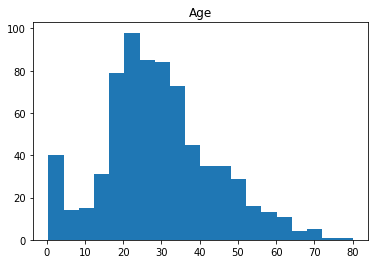

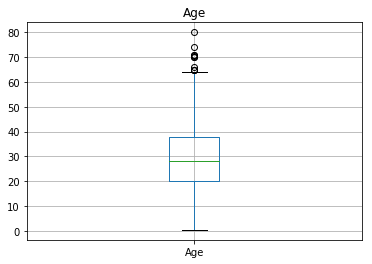

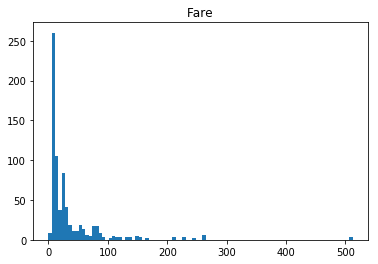

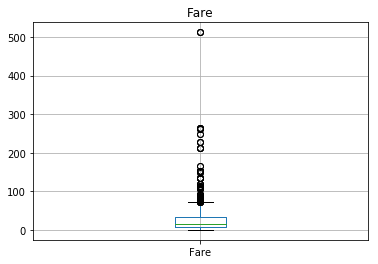

In [147]:
# Histogramas e Boxplots sem normalização
for i in [2,5]:
    plt.hist(ca.iloc[:, i], bins='auto')
    plt.title(columns[i])
    plt.show()

    ca.boxplot(column=columns[i])
    plt.title(columns[i])
    plt.show()

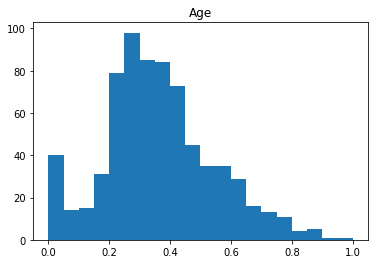

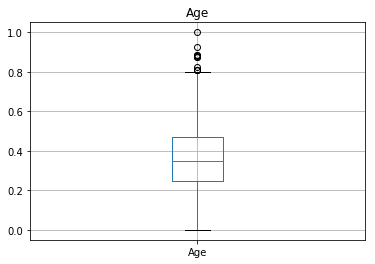

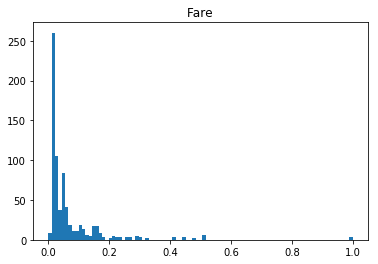

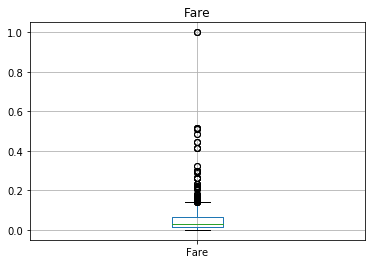

In [145]:
# Histogramas e Boxplots com normalização 0-1
for i in [2,5]:
    plt.hist(norm1.iloc[:, i], bins='auto')
    plt.title(columns[i])
    plt.show()

    norm1.boxplot(column=columns[i])
    plt.title(columns[i])
    plt.show()

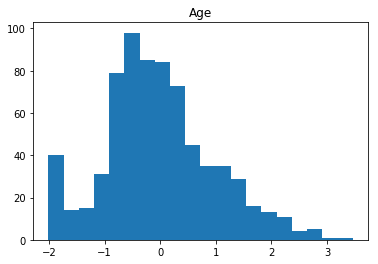

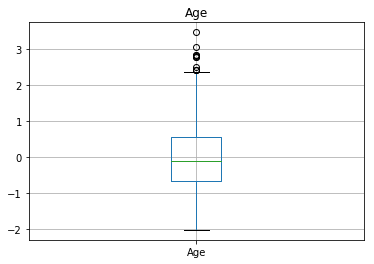

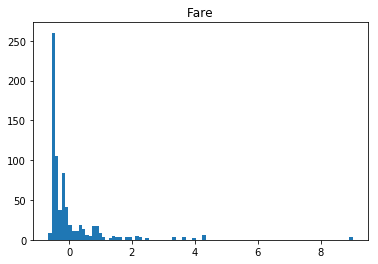

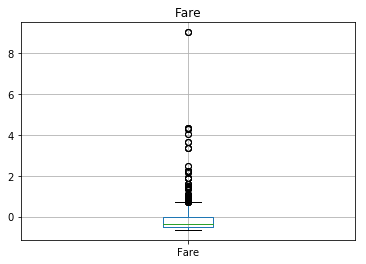

In [146]:
# Histogramas e Boxplots com normalização z-score
for i in [2,5]:
    plt.hist(norm2.iloc[:, i], bins='auto')
    plt.title(columns[i])
    plt.show()

    norm2.boxplot(column=columns[i])
    plt.title(columns[i])
    plt.show()

Comparando os gráficos com e sem normalização, podemos ver que as normalizações mantêm os dados consistentes com os originais, sem perder a "essência" destes.